In [1]:
columns = ["lyrics", "genre", "year"]

In [2]:
genres = ['pop', 'country', 'blues', 'jazz', 'reggae', 'rock', 'hiphop', "indie", "heavy", "dance"]

Assessment details: [link](https://docs.google.com/document/d/1I2-7dYkorOMwvYANKzWLxpHm3THEPi7OIsNz9wF48to/edit?fbclid=IwAR135YKjSzod3Gs9Y-E8RH3GL2zUdc6tiPhfnI3u4WLndp6CTQpE0Rns2eE)

### Load datasets

Data from [huggingface](https://huggingface.co/datasets/juliensimon/autonlp-data-song-lyrics)

In [3]:
# import os

# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

In [4]:
import ray
ray.init()

2022-04-06 17:01:22,606	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': None,
 'object_store_address': 'tcp://127.0.0.1:50116',
 'raylet_socket_name': 'tcp://127.0.0.1:39376',
 'webui_url': '127.0.0.1:8266',
 'session_dir': 'C:\\Users\\obada\\AppData\\Local\\Temp\\ray\\session_2022-04-06_17-01-19_810846_18448',
 'metrics_export_port': 40614,
 'gcs_address': '127.0.0.1:58378',
 'address': '127.0.0.1:58378',
 'node_id': '473bb0413a462409430e3a0b017ba52c7ff80814a7bcc90e3d2939fc'}

In [5]:
import datasets
import modin.pandas as pd
import numpy as np

data_autonlp = datasets.load_dataset("juliensimon/autonlp-data-song-lyrics")
data_autonlp = pd.DataFrame({"lyrics": data_autonlp["train"]["Lyric"], "genre": data_autonlp["train"]["Genre0"]})

Using custom data configuration juliensimon--autonlp-data-song-lyrics-71ae9d8c125e6e5a
Reusing dataset csv (C:\Users\obada\.cache\huggingface\datasets\csv\juliensimon--autonlp-data-song-lyrics-71ae9d8c125e6e5a\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
data_autonlp.insert(2, "year", np.nan)

In [7]:
data_autonlp.genre = data_autonlp.genre.map({"Hip Hop": "hiphop", "Pop": "pop", "Indie": "indie",
                       "Rock": "rock", 
                       "Heavy Metal": "heavy",
                       "Dance": "dance"})

In [8]:
data_autonlp.head()

,lyrics,genre,year
0,[Intro: Method Man w/ sample] + (Sunny valenti...,hiphop,NaN
1,[Sean Paul:]. Aye. It's Sean Paul 'long side. ...,pop,NaN
2,Beauty finds refuge in herself. Lovers wrapped...,indie,NaN
3,You've changed your tune. many times since we'...,rock,NaN
4,I got all these J's rolled up. And got all the...,hiphop,NaN


In [9]:
print(data_autonlp.shape)

(48493, 3)


Data from [Mendeley](https://data.mendeley.com/datasets/3t9vbwxgr5/2) 

In [10]:
# import pandas as pd
# from pandasgui import show

data_history = pd.read_csv("Music Dataset_ Lyrics and Metadata from 1950 to 2019/tcc_ceds_music.csv")
data_history = data_history[["lyrics", "genre", "release_date", "violence", "shake the audience", "sadness", "feelings", "danceability"]]
data_history.rename(columns={"release_date": "year"}, inplace=True, errors="raise")
data_history.head()
# show(data_history)

,lyrics,genre,year,violence,shake the audience,sadness,feelings,danceability
0,hold time feel break feel untrue convince spea...,pop,1950,0.063746,0.000598,0.380299,0.117175,0.357739
1,believe drop rain fall grow believe darkest ni...,pop,1950,0.096777,0.001284,0.001284,0.001284,0.331745
2,sweetheart send letter goodbye secret feel bet...,pop,1950,0.002770,0.002770,0.002770,0.225422,0.456298
3,kiss lips want stroll charm mambo chacha merin...,pop,1950,0.001548,0.021500,0.225889,0.001548,0.686992
4,till darling till matter know till dream live ...,pop,1950,0.001350,0.001350,0.068800,0.001350,0.291671


In [11]:
data_history.genre = data_history.genre.map({"pop": "pop",
                                             'country': "country", 
                                             'blues': "blues", 
                                             'jazz': "jazz", 
                                             'reggae': "reggae", 
                                             'rock': "rock", 
                                             'hip hop': "hiphop"})

In [12]:
data_history.shape

(28372, 8)

Data from Vagalume, sourced from [Kaggle](https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres) - Too much to use

In [13]:
# data_vagalume = pd.read_csv("lyrics-data.csv")
# data_vagalume = data_vagalume[data_vagalume.language == "en"]

In [14]:
# data_vagalume = data_vagalume[["Lyric"]]

In [15]:
# data_vagalume.rename(columns={"Lyric": "lyrics"}, inplace=True)
# data_vagalume.insert(1, "genre", np.nan)
# data_vagalume.insert(2, "year", np.nan)

In [16]:
# data_vagalume

### Compile

In [17]:
data_all = pd.concat([data_autonlp, data_history])

In [18]:
# Check for NAs in lyrics
data_all.isna().sum()

lyrics                    0
genre                     0
year                  48493
violence              48493
shake the audience    48493
sadness               48493
feelings              48493
danceability          48493
dtype: int64

### Lyrics cleaning

In [19]:
from cleantext import clean
import re

def cleaning(text):
    # Remove [Sean Paul: ] parts
    text = re.sub("\[[^][]*]", "", text)
    text = re.sub("\(.*?\)", "", text)
    
    # Remove recover short forms
    text = text.lower()
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    # Remove + signs
    text = re.sub("\+", "", text)
    
    # Remove "
    text = re.sub("""\"""", "", text)
    
    # Apply cleantext
    text = clean(
    text,
    fix_unicode=True,
    to_ascii=True,
    lower=True,
    normalize_whitespace=True,
    no_line_breaks=True,
    strip_lines=True,
    keep_two_line_breaks=False,
    no_urls=True,
    no_emails=True,
    no_phone_numbers=True,
    no_numbers=True,
    no_digits=True,
    no_currency_symbols=True,
    no_punct=True,
    no_emoji=True,
    replace_with_url='',
    replace_with_email='',
    replace_with_phone_number='',
    replace_with_number='',
    replace_with_digit='',
    replace_with_currency_symbol='',
    replace_with_punct='',
    lang='en')
    
    return text

In [20]:
datapoint = data_all.sample(1)["lyrics"].values[0]
# datapoint = data_all.iloc[0]["lyrics"]
print(datapoint)
print()
print(cleaning(datapoint))

Sitting up at night and I'm wondering why. My fairytale can't become a reality. Everything I've seen. Seems so out of reach. Maybe it's just that impossible oh. Where's my knight and shining armor to save me?. Feels like I've been waiting so long. Can you hear me calling out for you baby?. Take my hand make me the one aye. Since forever I have known. That the rockets stand alone. I am ready for that one that I can call my own. When I wait in my sleep. I can only think one thing. Where's my Jay-Z looking for Beyoncé?. Prince Charming looking for a same thing?. Will I ever ever ever find that Keke love love. Will I ever ever ever find that Keke love love. Will I ever ever ever find that Keke love love. Will I ever ever ever find that Keke love love. All I really want is a guy that can hold me down for real. One who cares how I feel. And that knows how to make me smile when I feel down. One who wipes my tears away when they come falling down. Knows just what to say when no one else is aro

In [21]:
data_all.lyrics = data_all.lyrics.apply(cleaning)

In [22]:
# Tokenized
from nltk import word_tokenize
data_all["tokenized"] = data_all.lyrics.apply(word_tokenize)

In [23]:
from string import ascii_lowercase

In [24]:
# Remove stopwords
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

# Mono-letter words
stopwords_en += list(ascii_lowercase)

data_all["tokenized_no_stopwords"] = data_all["tokenized"].apply(lambda l: [item for item in l if (item not in stopwords_en)])

In [25]:
data_all["tokenized_no_stopwords"]

0        [got, butter, aiyo, one, thing, sure, keep, ke...
1        [aye, sean, paul, long, side, mandem, called, ...
2        [beauty, finds, refuge, lovers, wrapped, insid...
3        [changed, tune, many, times, since, met, alway...
4        [got, rolled, got, drinks, poured, bought, bot...
                               ...                        
28367    [cause, fuck, leave, scar, tick, tock, clock, ...
28368    [minks, things, chain, ring, braclets, yap, fa...
28369    [get, ban, get, ban, stick, crack, relax, plan...
28370    [check, check, yeah, yeah, hear, thing, call, ...
28371    [remix, killer, alive, remix, thriller, trap, ...
Name: tokenized_no_stopwords, Length: 76865, dtype: object

In [26]:
# Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

data_all["tokenized_no_stopwords_lemmatized"] = data_all["tokenized_no_stopwords"].apply(
    lambda sent: [lemmatizer.lemmatize(word) for word in sent])

In [27]:
data_all["tokenized_no_stopwords_lemmatized"]

0        [got, butter, aiyo, one, thing, sure, keep, ke...
1        [aye, sean, paul, long, side, mandem, called, ...
2        [beauty, find, refuge, lover, wrapped, inside,...
3        [changed, tune, many, time, since, met, always...
4        [got, rolled, got, drink, poured, bought, bott...
                               ...                        
28367    [cause, fuck, leave, scar, tick, tock, clock, ...
28368    [mink, thing, chain, ring, braclets, yap, fame...
28369    [get, ban, get, ban, stick, crack, relax, plan...
28370    [check, check, yeah, yeah, hear, thing, call, ...
28371    [remix, killer, alive, remix, thriller, trap, ...
Name: tokenized_no_stopwords_lemmatized, Length: 76865, dtype: object

In [28]:
# Remove the non-English words
from nltk.corpus import words
words = set(words.words())

data_all["tokenized_no_stopwords_lemmatized"] = data_all["tokenized_no_stopwords_lemmatized"].apply(lambda sent_tok: [item for item in sent_tok if (item in words)])

In [29]:
# Compute the number of words
data_all["number_of_words"] = data_all["tokenized_no_stopwords_lemmatized"].apply(len)
data_all["number_of_unique_words"] = data_all["tokenized_no_stopwords_lemmatized"].apply(lambda l: len(set(l)))

In [30]:
data_all["number_of_unique_words"].describe()

count    76865.000000
mean        54.091043
std         39.200401
min          0.000000
25%         30.000000
50%         44.000000
75%         64.000000
max        599.000000
Name: number_of_unique_words, dtype: float64

In [31]:
data_all["lyrics_no_stopwords_lemmatized"] = data_all["tokenized_no_stopwords_lemmatized"].apply(lambda tok_sent: " ".join(tok_sent) or np.NaN)

In [32]:
data_all["lyrics_no_stopwords_lemmatized"]

0        got butter one thing sure keep keep nice crib ...
1        aye long side jay fi di gal em tell em drink l...
2        beauty find refuge lover wrapped inside lie be...
3        tune many time since met always recognize part...
4        got rolled got drink bought bottle club came d...
                               ...                        
28367    cause leave scar tick tock clock come knock do...
28368    mink thing chain ring yap fame come fool want ...
28369    get ban get ban stick crack relax plan attack ...
28370    check check yeah yeah hear thing call switch g...
28371    remix killer alive remix thriller trap bitch s...
Name: lyrics_no_stopwords_lemmatized, Length: 76865, dtype: object

In [33]:
# Check for additional NAs
data_all.isna().sum()

lyrics                                   0
genre                                    0
year                                 48493
violence                             48493
shake the audience                   48493
sadness                              48493
feelings                             48493
danceability                         48493
tokenized                                0
tokenized_no_stopwords                   0
tokenized_no_stopwords_lemmatized        0
number_of_words                          0
number_of_unique_words                   0
lyrics_no_stopwords_lemmatized          41
dtype: int64

In [34]:
data_all.dropna(subset=["lyrics_no_stopwords_lemmatized"], inplace=True)

### Removed unuseful fields

In [35]:
data_all.columns

Index(['lyrics', 'genre', 'year', 'violence', 'shake the audience', 'sadness',
       'feelings', 'danceability', 'tokenized', 'tokenized_no_stopwords',
       'tokenized_no_stopwords_lemmatized', 'number_of_words',
       'number_of_unique_words', 'lyrics_no_stopwords_lemmatized'],
      dtype='object')

In [36]:
data_all.drop(columns=["tokenized", "tokenized_no_stopwords", "tokenized_no_stopwords_lemmatized"], inplace=True)

In [37]:
# Unique words threshold
unique_words_threshold = 30
print("Removed, ", (data_all.number_of_unique_words < unique_words_threshold).sum(), " entries")
data_all = data_all[data_all.number_of_unique_words > unique_words_threshold]

Removed,  18886  entries


In [38]:
# Check for additional NAs
data_all.isna().sum()

lyrics                                0
genre                                 0
year                              41769
violence                          41769
shake the audience                41769
sadness                           41769
feelings                          41769
danceability                      41769
number_of_words                       0
number_of_unique_words                0
lyrics_no_stopwords_lemmatized        0
dtype: int64

### Visualization

In [39]:
# from pandasgui import show

In [40]:
# show(data_history)

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


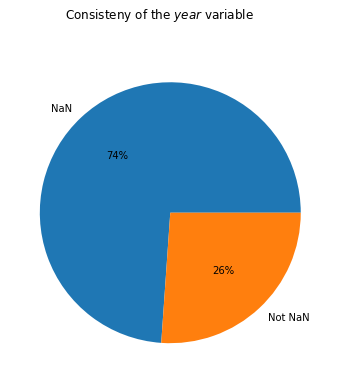

In [41]:
# Missing data
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
fig.set_facecolor("white")


year_nans = data_all.year.isna().value_counts()

ax.pie(year_nans.values, labels=["NaN", "Not NaN"], autopct='%.0f%%')
fig.suptitle("Consisteny of the $year$ variable")
fig.savefig("year_nans.png")

In [42]:
data_all.notna().sum()

lyrics                            56525
genre                             56525
year                              14756
violence                          14756
shake the audience                14756
sadness                           14756
feelings                          14756
danceability                      14756
number_of_words                   56525
number_of_unique_words            56525
lyrics_no_stopwords_lemmatized    56525
dtype: int64

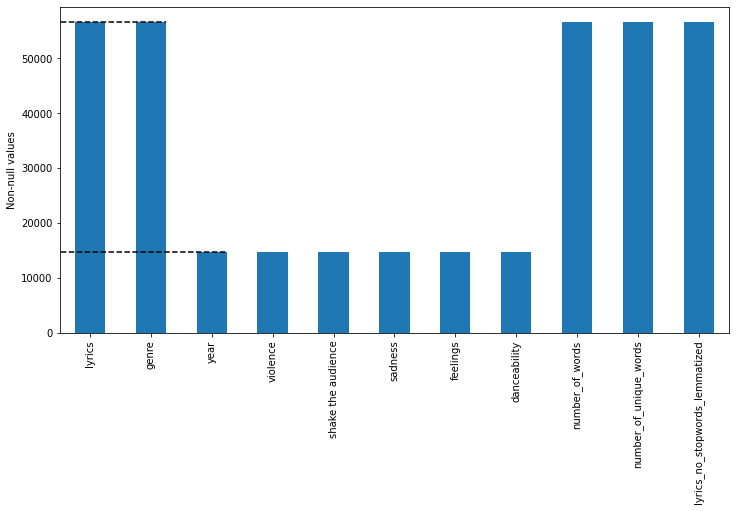

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

data_all.notna().sum().plot(kind='bar', ax=ax)
ax.hlines(y=56525, xmin=-1, xmax=1.25, color='black', linestyle='--')
ax.hlines(y=14756, xmin=-1, xmax=2.25, color='black', linestyle='--')

ax.set_ylabel("Non-null values")

fig.savefig("all_data_nans.png")

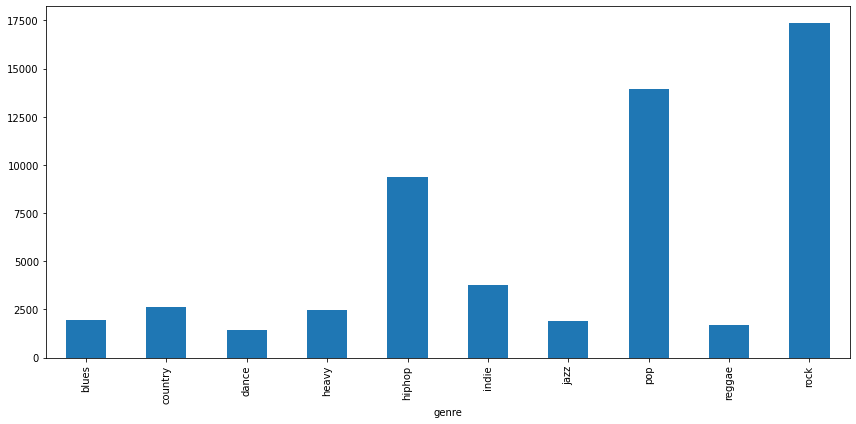

In [44]:
# Distribution of genres
fig, ax = plt.subplots(figsize=(12, 6))
data_all.groupby("genre").agg("count")["lyrics"].plot(kind='bar', ax=ax)

fig.tight_layout()
fig.savefig("genre_distribution.png")

### Save

In [46]:
data_all.to_csv("lyrics-dataset-v5.csv", index=False)

### Pre-processing of playlists dataset

In [23]:
import modin.pandas as pd

playlists = pd.read_csv("playlist-0.csv")
playlists = playlists[["name", 'lyrics']]

In [25]:
from cleantext import clean
import re

def playlists_cleaning(text):
    # Remove [Sean Paul: ] parts
    text = re.sub("\[[^][]*]", "", text)
    text = re.sub("\(.*?\)", "", text)
    
    # Remove + signs
    text = re.sub("\+", "", text)
    
    # Remove "
    text = re.sub("""\"""", "", text)
    
    # Apply cleantext
    text = clean(
    text,
    fix_unicode=True,
    to_ascii=True,
    lower=True,
    normalize_whitespace=True,
    no_line_breaks=True,
    strip_lines=True,
    keep_two_line_breaks=False,
    no_urls=True,
    no_emails=True,
    no_phone_numbers=True,
    no_numbers=True,
    no_digits=True,
    no_currency_symbols=True,
    no_punct=False,
    no_emoji=True,
    replace_with_url='',
    replace_with_email='',
    replace_with_phone_number='',
    replace_with_number='',
    replace_with_digit='',
    replace_with_currency_symbol='',
    replace_with_punct=' ',
    lang='en')
    
    # Remove the song name + lyrics 
    text = re.sub("^.*?(?:lyrics )", "", text)
    
    return text

playlists["lyrics"] = playlists["lyrics"].apply(playlists_cleaning)

In [27]:
playlists.to_csv("playlists-processed.csv", index=False)